In [1]:
%cd ../..

/cis/home/zfang23/code/LearnedRegularizers


In [2]:
import argparse
import datetime
import logging
import os
import time
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from deepinv.loss.metric import PSNR
from deepinv.optim.optimizers import optim_builder
from deepinv.optim.prior import PnP
from deepinv.utils.plotting import plot
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

from operators import get_evaluation_setting
from priors.lpn.lpn import LPNPrior

if torch.backends.mps.is_available():
    # mps backend is used in Apple Silicon chips
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("device: ", device)
torch.random.manual_seed(0)  # make results deterministic

pretrained_path = "weights/lpn_64_bsd/LPN.pt"

device:  cuda


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
problem = "Denoising"
dataset, physics, data_fidelity = get_evaluation_setting(problem, device)

In [4]:
regularizer = LPNPrior(pretrained=pretrained_path).to(device)
regularizer.eval()

init weights


LPNPrior(
  (lpn): LPN(
    (lin): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (6): Conv2d(256, 64, kernel_size=(8, 8), stride=(1, 1), bias=False)
      (7): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
    (res): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(1, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(1, 256, k

torch.Size([1, 1, 129, 137]) tensor(0.0022) tensor(0.9968)


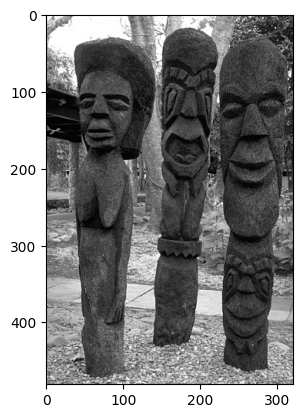

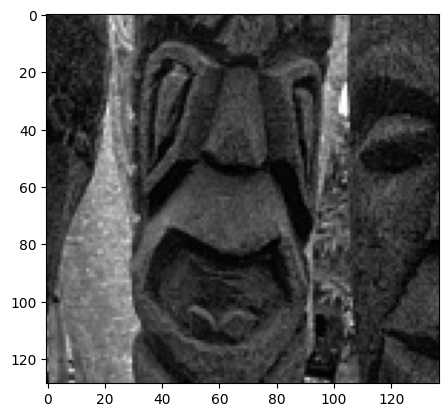

In [5]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
for i, x in enumerate(dataloader):
    if i == 0:
        break
plt.figure()
plt.imshow(x[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)
px, py = 80, 120
x = x[..., px : px + 129, py : py + 137]
print(x.shape, x.min(), x.max())
plt.figure()
plt.imshow(x[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)

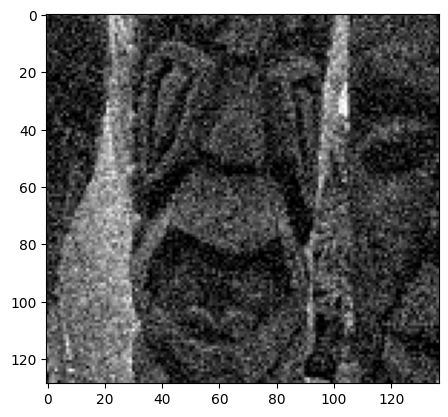

In [6]:
noisy = x + 0.1 * torch.randn_like(x)
plt.imshow(noisy[0, 0].cpu(), cmap="gray", vmin=0, vmax=1)

In [7]:
rep = 6
xhats = []
priors = []
prior_noisy = regularizer.g(noisy.to(device)).item()
prior_clean = regularizer.g(x.to(device)).item()
xhat = noisy.to(device)
for i in range(rep):
    with torch.no_grad():
        xhat = regularizer.prox(xhat)
    xhats.append(xhat.detach().cpu())
    priors.append(regularizer.g(xhat).detach().cpu())

/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback

         Current function value: 4259.776367
         Iterations: 12
         Function evaluations: 50
         Gradient evaluations: 39
final mse:  1.2407139e-05


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback

         Current function value: 5083.312988
         Iterations: 20
         Function evaluations: 64
         Gradient evaluations: 53
final mse:  7.1073464e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:403: RuntimeWarning: overflow encountered in cast
  alpha1 = min(alpha1, amax)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.1

         Current function value: 5392.152344
         Iterations: 13
         Function evaluations: 67
         Gradient evaluations: 56
final mse:  4.2828024e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: 5572.324219
         Iterations: 5
         Function evaluations: 71
         Gradient evaluations: 61
final mse:  2.9507928e-06


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback

         Current function value: 5633.095703
         Iterations: 5
         Function evaluations: 31
         Gradient evaluations: 20
final mse:  8.100169e-07


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback

         Current function value: 5666.478516
         Iterations: 5
         Function evaluations: 29
         Gradient evaluations: 21
final mse:  3.472292e-07


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1680: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback

         Current function value: 5681.494141
         Iterations: 4
         Function evaluations: 42
         Gradient evaluations: 33
final mse:  3.587766e-07


/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:324: RuntimeWarning: overflow encountered in cast
  if stp > self.stpmax:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:385: RuntimeWarning: overflow encountered in cast
  if stp == self.stpmax and f <= ftest and g <= self.gtest:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/numpy/_core/_methods.py:116: RuntimeWarning: overflow encountered in cast
  return um.clip(a, min, max, out=out, **kwargs)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_dcsrch.py:469: RuntimeWarning: overflow encountered in cast
  if abs(self.sty - self.stx) >= p66 * self.width1:
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.12/site-packages/scipy/optimize/_linesearch.py:403: RuntimeWarning: overflow encountered in cast
  alpha1 = min(alpha1, amax)
/cis/home/zfang23/miniconda3/envs/learnR/lib/python3.1

         Current function value: 5694.471680
         Iterations: 2
         Function evaluations: 42
         Gradient evaluations: 30
final mse:  1.4855497e-05


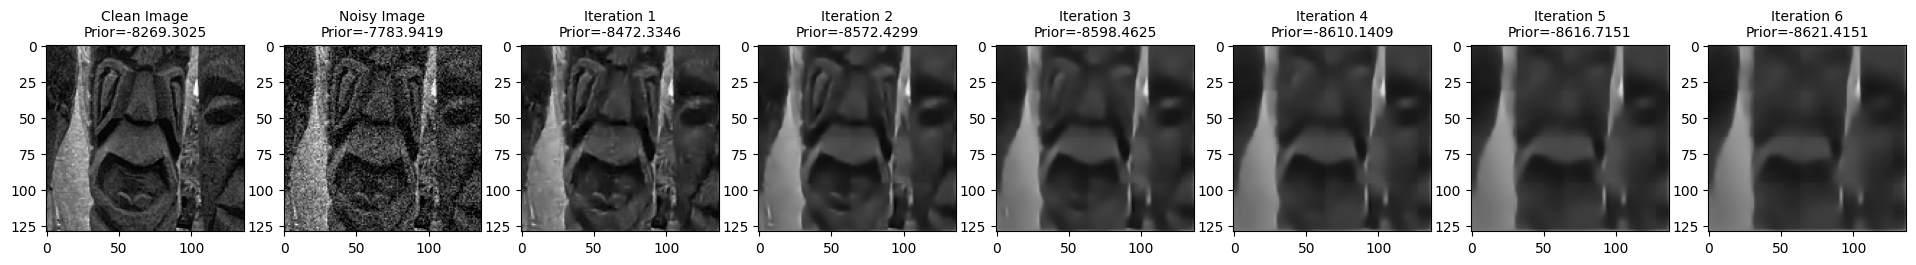

In [8]:
fig, axs = plt.subplots(1, rep + 2, figsize=((rep + 2) * 3, 3))

ax = axs[0]
ax.imshow(x[0, 0].cpu().detach(), cmap="gray", vmin=0, vmax=1)
ax.set_title(f"Clean Image\nPrior={prior_clean:.4f}", fontsize=10)

ax = axs[1]
ax.imshow(noisy[0, 0].cpu().detach(), cmap="gray", vmin=0, vmax=1)
ax.set_title(f"Noisy Image\nPrior={prior_noisy:.4f}", fontsize=10)


for i in range(rep):
    xhat = xhats[i]
    prior = priors[i].item()
    ax = axs[i + 2]
    ax.imshow(xhat[0, 0].cpu().detach(), cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"Iteration {i+1}\nPrior={prior:.4f}", fontsize=10)